In [7]:
import os, sys
import pyphase
from pyphase import *
import numpy as np 
from PIL import Image
import numpy as np
from math import *
import matplotlib.pyplot as pyplot
import scipy.ndimage
from pyphase.config import *
from matplotlib.pyplot import pause
from scipy import interpolate
from scipy import ndimage 
import neurite as ne 

In [8]:
x_data_dir = "0 mm"
y_data_dir = "1 mm"

In [9]:
for x_tif in sorted(os.listdir(x_data_dir))[:180]:
    x_data = np.array([np.array(Image.open(os.path.join(x_data_dir, x_tif)))])  
for y_tif in sorted(os.listdir(y_data_dir))[:180]: 
    y_data = np.array([np.array(Image.open(os.path.join(y_data_dir, y_tif)))])

In [10]:
class TIEHOM:
    """ 
    Modified from https://gitlab.in2p3.fr/mlanger/pyPhase
    Transport of Intensity Equation for homogeneous objects (or "Paganin's algorithm") [1] 
    
       Parameters
    shape : tuple of ints, optional
        Size of images (ny, nx) for creation of frequency variables etc.
    pixel_size : float, optional
        In m.
    distance : list of floats, optional
        Effective propagation distances in m.
    energy : float, optional
        Effective energy in keV.
    delta_alpha : tuple of floats, optional
        Regularisation parameters. First entry for LF, second for HF. 
        Typically [1e-8, 1e-10].
    pad : int
        Padding factor (default 2).

    Attributes
    ----------
    nx : int
        Number of pixels in horizontal direction.
    ny : int
        Number of pixels in horizontal direction.
    pixel_size : tuple of floats
        Pixel size [x, y] in µm.
    ND : int
        Number of positions.
    energy : float
        Energy in keV.
    alpha : tuple of floats
        First entry for LF, second for HF. Tyically [1e-8, 1e-10].
    distance : numpy array
        Effective propagation distances in m.
    padding : int
        Padding factor.
    sample_frequency : float
        Reciprocal of pixel size in lengthscale.
    nfx : int
        Number of samples in Fourier domain (horizontal).
    nfy : int
        Number of samples in Fourier domain (vertical).
    fx : numpy array
        Frequency variable (horizontal), calculated by frequency_variable.
    fy : numpy array
        Freuency variable (vertical).
    alpha_cutoff : float
        Cutoff frequency for regularization parameter in normalized frequency.
    alpha_slope : float
        Slope in regularization parameter.

    
    References
    ----------
    [1] Paganin et al. J. Microsc. 206 (2002) 33
    """
        
    def __init__(self, image=None, delta_beta=500, **kwargs):    
        self.lengthscale=10e-6
        self.delta_beta=delta_beta
        self.padding = 1
        self.nx=image.shape[0]
        self.ny=image.shape[1]
        self.pixel_size = 1e-6   
        self.length_scale = 1e-6
        self.sample_frequency = int(self.length_scale/self.pixel_size) - 1
        self.ND = 2 
        self.distance = np.array([0, 0.001])
        self.nfx = self.padding*self.nx 
        self.nfy = self.padding*self.ny  
        self.energy = 500 #KeV 
        self.Lambda = 12.4e-10 / self.energy
        self.Fresnel_number = self.Lambda * self.distance / (self.lengthscale**2)  
        self.fx, self.fy = self.frequency_variable(self.nfx, self.nfy, self.sample_frequency) 
        
    def frequency_variable(self, nfx, nfy, sample_frequency):
        """
        Calculate frequency variables.
        
        Parameters
        ----------
        nfx : int
            Number of samples in x direction
        nfy : int
            Number of samples in y direction
        sample_frequency : float
            Reciprocal of pixel size in 1/m
            
        Returns
        -------
        nparray
            Frequency variables as an array of size  [nfy, nfx, 2]
            
        Notes
        -----
        Follows numpy FFT convention. Zero frequency at [0,0], [1:n//2] 
        contain the positive frequencies, [n//2 + 1:] n the negative 
        frequencies in increasing order starting from the most negative 
        frequency.
        """
        
        if type(sample_frequency) == int:
            sample_frequency = np.array([sample_frequency, sample_frequency]) #TODO: refactor
        
        x=0
        x=np.append(x, np.linspace(sample_frequency[0]/nfx, sample_frequency[0]/2, nfx//2))
        x=np.append(x, np.linspace(-sample_frequency[0]/2+sample_frequency[0]/nfx, -sample_frequency[0]/nfx, int(nfx//2-1+(np.ceil(nfx/2)-nfx//2))))
        
        y=0
        y=np.append(y, np.linspace(sample_frequency[1]/nfy, sample_frequency[1]/2, nfy//2))
        y=np.append(y, np.linspace(-sample_frequency[1]/2+sample_frequency[1]/nfy, -sample_frequency[1]/nfy, int(nfy//2-1+(np.ceil(nfy/2)-nfy//2))))
        return np.meshgrid(x, y) 
    
    def _compute_factors(self):
        """Calculate TIEHOM factors. Overrides PhaseRetrievalAlgorithm2D."""
        self.TIEHOM_factor = [0 for xxx in range(self.ND)]  
        for distance in range(self.ND):
            self.TIEHOM_factor[distance] = 1 + self.Fresnel_number[distance] * np.pi * self.delta_beta * ((self.fx ** 2) + (self.fy ** 2)) 
        return self.TIEHOM_factor 
    
    def _algorithm(self, dataset, positions=None):
        """Reconstruct one image or a set of images using TIEHOM."""
        #TODO: Needs verification on simpler images

        FID=np.fft.fft2(dataset) 

        numerator_TIEHOM = np.zeros((self.nfy, self.nfx))
        denominator_TIEHOM = numerator_TIEHOM.copy()  
        
        TIEHOM_factor = self._compute_factors() 
        
        phase = 1/2 * self.delta_beta * np.log(np.real(np.fft.ifft2(FID / TIEHOM_factor)))
        
        attenuation = -1/(self.delta_beta) * phase

        return phase, attenuation


In [28]:
phase_array, attenuation_array = TIEHOM(image=np.array(x_data[0]))._algorithm(dataset=np.array([x_data[0], y_data[0]]), positions=[0, 0.001])

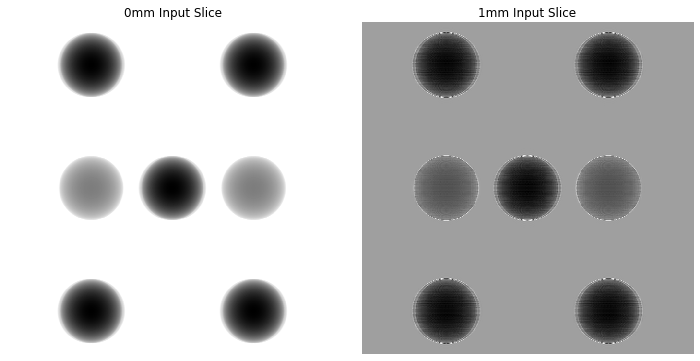

In [29]:
ne.plot.slices([x_data[0], y_data[0]], titles=["0mm Input Slice", "1mm Input Slice"], cmaps=["gray"], width=10);

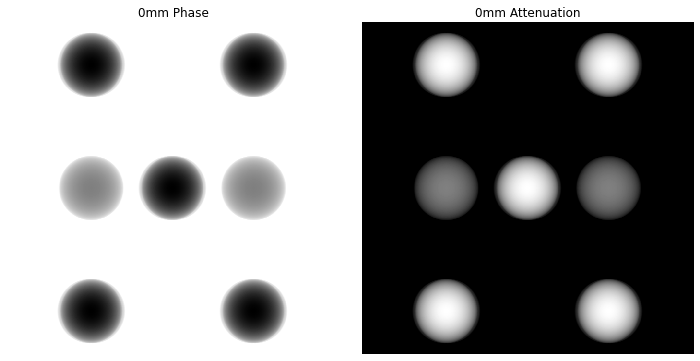

In [30]:
ne.plot.slices([phase_array[0], attenuation_array[0]], 
               titles=["0mm Phase", "0mm Attenuation"], 
               cmaps=["gray"], 
               width=10);

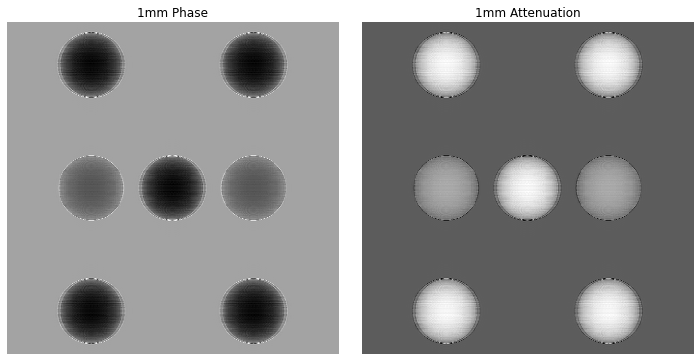

In [31]:
ne.plot.slices([phase_array[1], attenuation_array[1]], 
               titles=["1mm Phase", "1mm Attenuation"], 
               cmaps=["gray"], 
               width=10);